## Customer segmentation for Online Retail

***Context***

Online retail is a transnational data set which contains all the transactions occurring between 01/12/2010 
and 12/10/2011 (mm/dd/yyyy) for a UK-based and registered non-store online retail. 
The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers. 
*(This data come from Kaggle.com - https://www.kaggle.com/hellbuoy/online-retail-customer-clustering).*

***Business Goal***

We will be using the online retail trasnational dataset to build a RFM clustering 
and choose the best set of customers which the company should target.

***Solution***
* Cleaning data, refinery data and apply RFM analysis (Recency, Frequency and Monetary) to feature engineering.
* Using the algorithm Kmean to create the clustering model
* Applying Elbow and Silhouette methods to determine optimal number of clusters
* Evaluating the model by Silhouette Score
* Trying others algorithms such as Agglomerative hierarchical and DBSCAN clustering to compare the results to Kmean.
* Analyze the result to gain the insights



In [1]:
#Import the useful libraries
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from numpy import where
from numpy import unique
from sklearn.datasets import make_classification
from sklearn.cluster import AgglomerativeClustering
from datetime import timedelta
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D 
from yellowbrick.cluster import KElbowVisualizer
%matplotlib inline

# read data from a file .csv to dataframe
df = pd.read_csv("OnlineRetail.csv", encoding = 'unicode_escape')

In [2]:
# Get the quartile of data to apply RFM score method
# Arguments: x = value, q1 = 25th percentile, q2 = 50th percentile, q3 = 75th percentile
def get_quartile(x,q1,q2,q3):
    if x <= q1:
        return 1
    elif x <= q2:
        return 2
    elif x <= q3: 
        return 3
    else:
        return 4

In [3]:
# Calculate the RFM score
# Arguments: r = quartile of recency, f = quartile of frequency and m = quartile of monetary
def rfm_score(r,f,m):
    score = 0
    score = r*100 + f*10 + m
    return score

In [4]:
# Get name of customer cluster
# Arguments: rfm_score
def get_name_customer_cluster(rfm_score):
    name_cluster = ''
    # define label of customer cluster by rfm score
    # convert rfm_score to string
    rfm_score_str = str(rfm_score)
    if rfm_score_str == '144':
        name_cluster = "1-Best Customers"
    elif rfm_score_str[1] == '4': # 'X4X'
        name_cluster = "2-Loyal Customers"
    elif rfm_score_str[2] == '4': # 'XX4'
        name_cluster = "3-Big Spenders"
    elif rfm_score_str == '344':
        name_cluster = "4-Almost Lost"
    elif rfm_score_str == '444':
        name_cluster = "5-Lost Customers"
    elif rfm_score_str == '411':
        name_cluster = "6-Lost Cheap Customers"
    else:
        name_cluster = "Undefined"
    return name_cluster

In [5]:
# Plot 2D scatter function
def plot2D(x,y,title_x,title_y,labels):    
    plt.scatter(x, y, c=labels, cmap=plt.cm.jet,alpha=0.5)
    plt.xlabel(title_x, fontsize=15)
    plt.ylabel(title_y, fontsize=15)
    plt.show()

In [6]:
#Plot 3D scatter function
def plot3D(x,y,z,title_x,title_y,title_z,labels):
    fig = plt.figure(1, figsize=(8, 6))
    plt.clf()
    #ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    ax = Axes3D(fig, auto_add_to_figure=False, rect=[0, 0, .95, 1], elev=48, azim=134)
    fig.add_axes(ax)
    
    plt.cla()
    ax.set_xlabel(title_x)
    ax.set_ylabel(title_y)
    ax.set_zlabel(title_z)

    ax.scatter(x, y, z, c= labels, cmap=plt.cm.jet)


**Exploratory Data Analysis and Cleaning Data phase**


In [7]:
#Fisrt view data
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [8]:
# Descriptive statistics
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [9]:
# check duplicate data value
df.duplicated().value_counts

<bound method IndexOpsMixin.value_counts of 0         False
1         False
2         False
3         False
4         False
          ...  
541904    False
541905    False
541906    False
541907    False
541908    False
Length: 541909, dtype: bool>

In [10]:
# We can see negative quantities and negative unit prices on above descriptive statistics, they are not valid. 
# Need to drop them.
df.drop(df[(df['UnitPrice'] < 0) | (df['Quantity'] < 0)].index, inplace=True)
df.describe()

,Quantity,UnitPrice,CustomerID
count,531283.000000,531283.000000,397924.000000
mean,10.655299,3.898954,15294.315171
std,156.830617,35.876279,1713.169877
min,1.000000,0.000000,12346.000000
25%,1.000000,1.250000,13969.000000
50%,3.000000,2.080000,15159.000000
75%,10.000000,4.130000,16795.000000
max,80995.000000,13541.330000,18287.000000


In [11]:
# Continue to explore data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 531283 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    531283 non-null  object 
 1   StockCode    531283 non-null  object 
 2   Description  530691 non-null  object 
 3   Quantity     531283 non-null  int64  
 4   InvoiceDate  531283 non-null  object 
 5   UnitPrice    531283 non-null  float64
 6   CustomerID   397924 non-null  float64
 7   Country      531283 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 36.5+ MB


In [12]:
# The null customerID values appear, we check again them by using isnull()
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description       592
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133359
Country             0
dtype: int64

In [13]:
#The null customerID can be miss or belong to anonymous user, so they are out of scope of this analysis
# Drop out the null customerID
df.dropna(subset=['CustomerID'], inplace=True)
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [14]:
#Convert type of customerID to int and InvoiceDate to Datetime
df['CustomerID'] = df['CustomerID'].astype(int)
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

**Feature Engineering Phase (by using RFM analysis)**

The transactions occurring of data are between 01/12/2010 and 12/10/2011, this range is not long. So we will analyze all data on this period by RFM method.





In [15]:
# Calculate the monetary for each product
df["Monetary"] = df["UnitPrice"]*df["Quantity"]
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Monetary
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34


In [16]:
# Get datetime on the data was retrieved, this date is used to calculate the recency for each customer 
retrieved_data_date = df["InvoiceDate"].max()
#Group by customer
customer = df.groupby('CustomerID')
customer = customer.agg(LastDate=('InvoiceDate', np.max), Frequency=("InvoiceNo", pd.Series.nunique), Monetary=("Monetary", np.sum))

#Recency is the number of days counted from the last transaction of customer to the date on the data was retrieved
customer["Recency"] = (retrieved_data_date-customer["LastDate"])/timedelta(days=1)
customer.head()

,LastDate,Frequency,Monetary,Recency
CustomerID,,,,
12346,2011-01-18 10:01:00,1,77183.60,326.304167
12347,2011-10-31 12:25:00,7,4310.00,40.204167
12348,2011-09-25 13:13:00,4,1797.24,76.170833
12349,2011-11-21 09:51:00,1,1757.55,19.311111
12350,2011-02-02 16:01:00,1,334.40,311.054167


In [17]:
# Drop LastDate column
customer.drop('LastDate', axis = 1, inplace = True)
# Descriptive statistics for 3 features R,F and M
customer.describe()

,Frequency,Monetary,Recency
count,4339.000000,4339.000000,4339.000000
mean,4.271952,2053.793018,105.639007
std,7.705493,8988.248381,115.082312
min,1.000000,0.000000,0.000000
25%,1.000000,307.245000,22.191667
50%,2.000000,674.450000,61.077778
75%,5.000000,1661.640000,161.688194
max,210.000000,280206.020000,697.309722


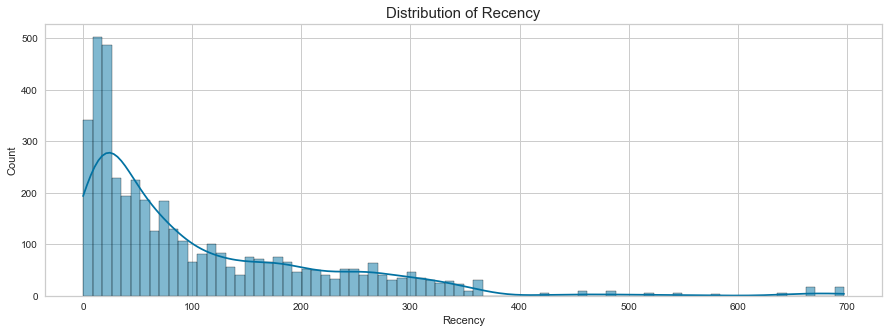

In [18]:
#Plot distribution of Recency feature
plt.subplots(figsize=(15, 5))
sb.histplot(customer['Recency'], kde=True, bins=80)
plt.title('Distribution of Recency', fontsize = 15)
plt.xlabel('Recency')
plt.ylabel('Count');


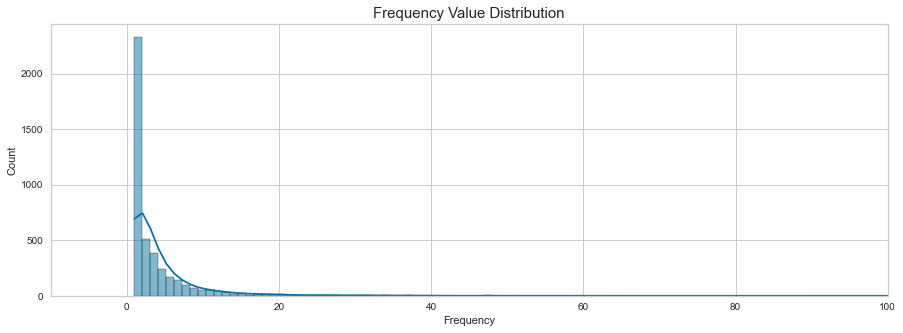

In [19]:
#Plot distribution of Frequency feature
plt.figure(figsize=(15, 5))
sb.histplot(customer['Frequency'], kde=True, bins=200)
plt.title('Frequency Value Distribution', fontsize = 15)
plt.xlim(-10, 100)
plt.xlabel('Frequency')
plt.ylabel('Count');

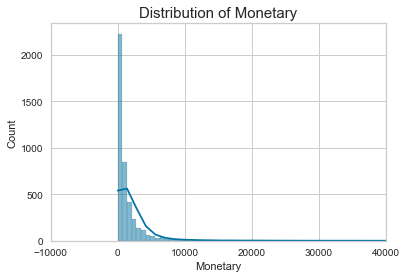

In [20]:
#Plot distribution of Monetary feature
sb.histplot(customer['Monetary'], kde=True, bins=400)
plt.title('Distribution of Monetary', fontsize = 15)
plt.xlim(-10000, 40000)
plt.xlabel('Monetary')
plt.ylabel('Count');

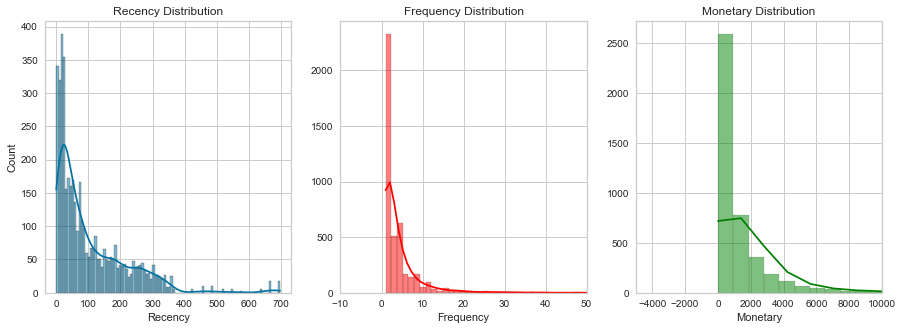

In [21]:
# summary of Recency, Frequency, Monetary distributions
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sb.histplot(customer['Recency'],kde=True,bins=100)
plt.title('Recency Distribution')
plt.xlabel('Recency')
plt.ylabel('Count')

plt.subplot(1,3,2)
sb.histplot(customer['Frequency'],kde=True,color='red',bins=150)
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('')
plt.xlim(-10, 50)

plt.subplot(1,3,3)
sb.histplot(customer['Monetary'],kde=True,color='green',bins=300)
plt.title('Monetary Distribution')
plt.xlabel('Monetary')
plt.ylabel('')
plt.xlim(-5000, 10000)
plt.show()

**Normalization data phase**

After analyzing the distributions of R,F,M features, we need to normalize them before fitting into model.

In [22]:
#Standardization data
from sklearn.preprocessing import StandardScaler
#Save standarded data into customer_scaled dataframe
customer_scaled = pd.DataFrame(StandardScaler().fit_transform(customer))
customer_scaled.describe()

,0,1,2
count,4.339000e+03,4.339000e+03,4.339000e+03
mean,1.965087e-17,-4.093931e-17,5.895261e-17
std,1.000115e+00,1.000115e+00,1.000115e+00
min,-4.246749e-01,-2.285239e-01,-9.180488e-01
25%,-4.246749e-01,-1.943370e-01,-7.251936e-01
50%,-2.948824e-01,-1.534784e-01,-3.872564e-01
75%,9.449517e-02,-4.363455e-02,4.870918e-01
max,2.670196e+01,3.094978e+01,5.141875e+00


In [23]:
#Rename columns to clear
customer_scaled.rename(columns = {0:'Frequency',1:'Monetary',2:'Recency'}, inplace = True)
customer_scaled.head()

,Frequency,Monetary,Recency
0,-0.424675,8.359634,1.917676
1,0.354080,0.251046,-0.568657
2,-0.035297,-0.028546,-0.256091
3,-0.424675,-0.032963,-0.750227
4,-0.424675,-0.191315,1.785147


<AxesSubplot:xlabel='Frequency', ylabel='Density'>

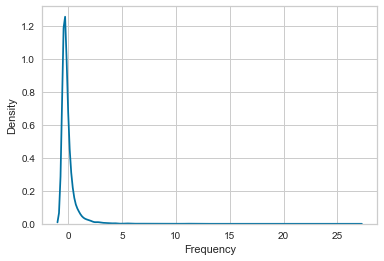

In [24]:
#Plot the standardized distribution of Frequency feature
sb.kdeplot(customer_scaled['Frequency'])

<AxesSubplot:xlabel='Monetary', ylabel='Density'>

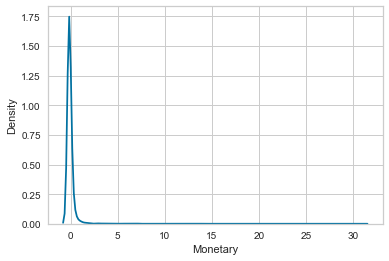

In [25]:
#Plot the standardized distribution of Monetary feature
sb.kdeplot(customer_scaled['Monetary'])

<AxesSubplot:xlabel='Recency', ylabel='Density'>

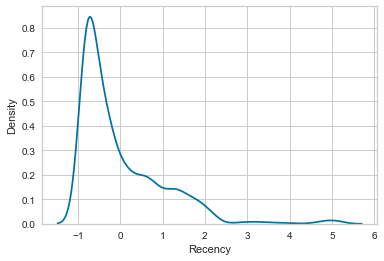

In [26]:
#Plot the standardized distribution of Recency feature
sb.kdeplot(customer_scaled['Recency'])

**Building model phase**

Before building the model, we find the optimal number of clusters k by using Elbow and Silhouette methods

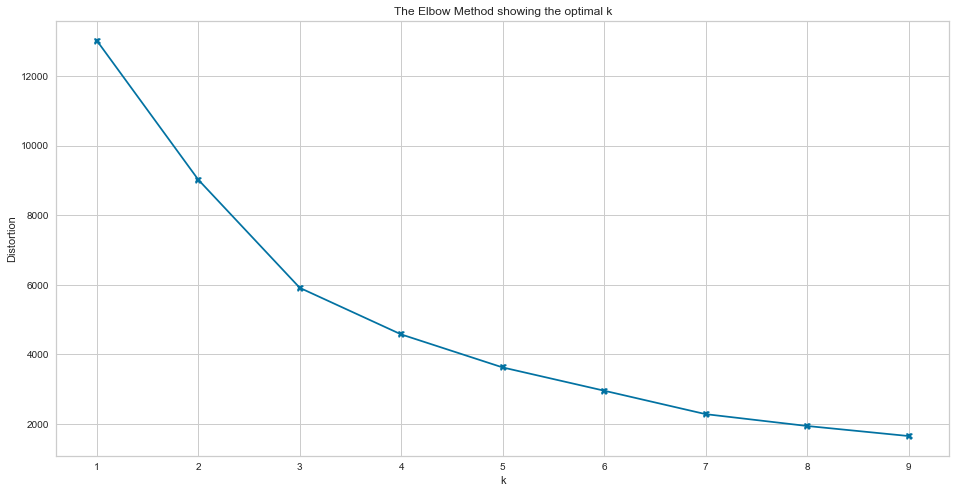

In [27]:
# Using Elbow method on Kmean
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(customer_scaled)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bX-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Base on above figure, it seems that k = 3 or 4 values are best. Now, we will use Yellowbrick method to determine the best value.

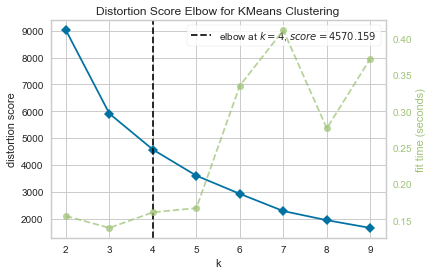

In [28]:
# Apply Yellowbrick method to determine the best number of clusters.
kmeans = KMeans()
fig = KElbowVisualizer(kmeans, k = (2,10))
fig.fit(customer_scaled)
fig.show();

Yellowbrick method show that k = 4 is the best. Now we will use Silhouette method to verify it.

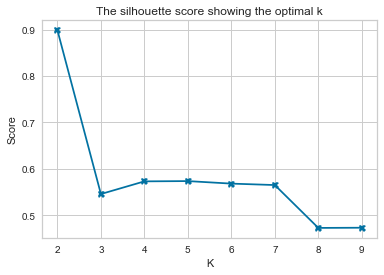

In [29]:
#Use silhouette score to find optimal number of clusters for KMean
range_n_clusters = list (range(2,10))
scores =[]
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(customer_scaled)
    score = silhouette_score(customer_scaled, preds)
    scores.append(score)
    #print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    
# Plot silhouette score
#plt.figure(figsize=(12,8))
plt.plot(range_n_clusters, scores, 'bX-')
plt.xlabel('K')
plt.ylabel('Score')
plt.title('The silhouette score showing the optimal k')
plt.show()

With Silhouette methode, it seem that k=4 is the best. Comparing both methods Elbow and Silhouette, we find that k=4 is the best. So the optimal number of clusters is 4. Now we apply K-Mean to segment customers.

**K-Mean**

In [30]:
# Assign the number of clusters to 4
clusterNum = 4
#Build Kmean model
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(customer_scaled)
km_labels = k_means.labels_
# Calculate Silhoutte Score
km_score = silhouette_score(customer_scaled, km_labels, metric='euclidean')
# Print the score
print('Silhouette Score: %.3f' % km_score)

Silhouette Score: 0.573


In [31]:
#Make a dataframe of customer for the result of Kmean
customer["Cluster_Km"] = km_labels
customer.head()

,Frequency,Monetary,Recency,Cluster_Km
CustomerID,,,,
12346,1,77183.60,326.304167,3
12347,7,4310.00,40.204167,0
12348,4,1797.24,76.170833,0
12349,1,1757.55,19.311111,0
12350,1,334.40,311.054167,2


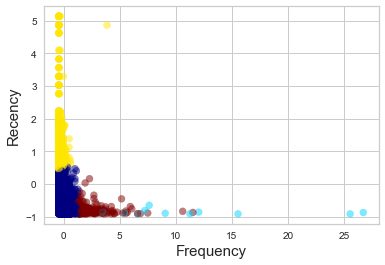

In [32]:
#Plot the clusters on 2D Frequency and Recency
plot2D(customer_scaled['Frequency'], customer_scaled['Recency'], 'Frequency','Recency',km_labels)


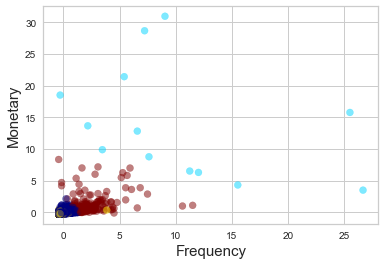

In [33]:
#Plot the clusters on 2D Frequency and Monetary
plot2D(customer_scaled['Frequency'], customer_scaled['Monetary'], 'Frequency','Monetary',km_labels)

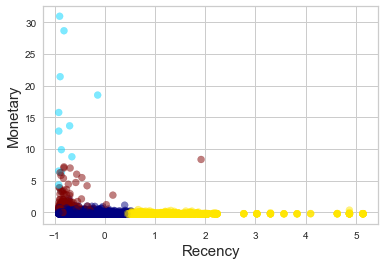

In [34]:
#Plot the clusters on 2D Recency and Monetary
plot2D(customer_scaled['Recency'], customer_scaled['Monetary'], 'Recency','Monetary',km_labels)

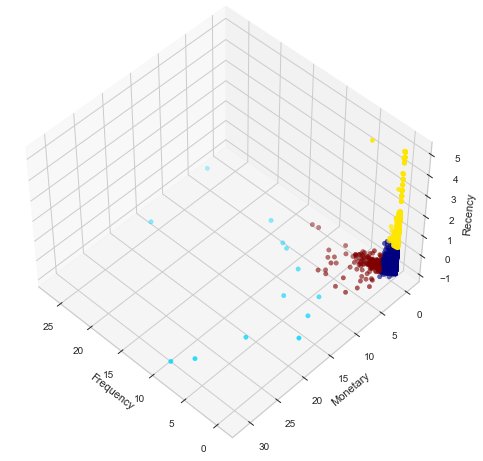

In [35]:
#Plot the clusters on 3D Recency,Frequency and Monetary
plot3D(customer_scaled['Frequency'], customer_scaled['Monetary'], customer_scaled['Recency'],'Frequency','Monetary','Recency',km_labels)

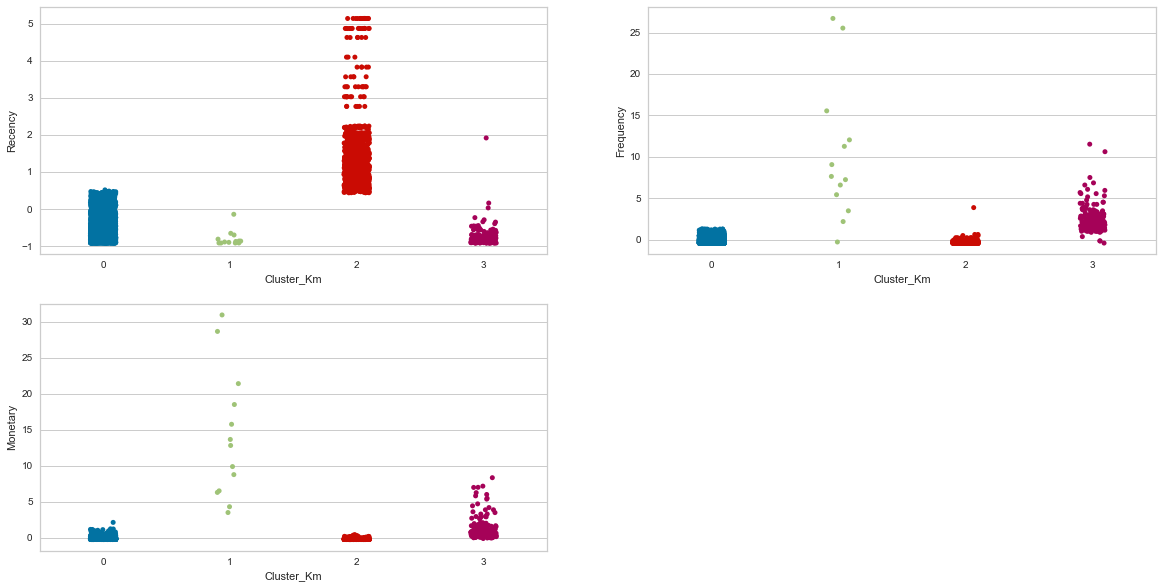

In [36]:
# make a copy customer scaled list to strip plot
customer_scaled_km = customer_scaled.copy()
customer_scaled_km['Cluster_Km'] = km_labels
# Strip plot for Recency, Frequency, Monetary
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
sb.stripplot(x='Cluster_Km', y='Recency', data=customer_scaled_km[['Cluster_Km','Recency']])

plt.subplot(2,2,2)
sb.stripplot(x='Cluster_Km', y='Frequency', data=customer_scaled_km[['Cluster_Km','Frequency']])

plt.subplot(2,2,3)
sb.stripplot(x='Cluster_Km', y='Monetary', data=customer_scaled_km[['Cluster_Km','Monetary']])

plt.show()

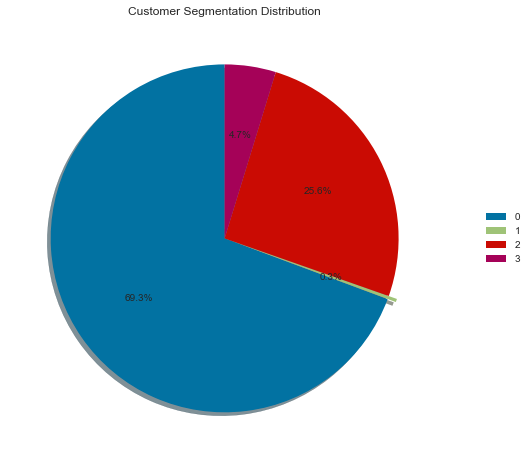

In [37]:
# Show pie chart of customer segmentation distribution
plt.figure(figsize=(8,8))
expl = (0, 0.05, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
plt.pie(customer['Cluster_Km'].value_counts().sort_index(),explode=expl,autopct='%1.1f%%',shadow=True,startangle=90)
plt.legend(customer['Cluster_Km'].value_counts().sort_index().index,bbox_to_anchor=(1.2,0.5),loc='center right')
plt.title('Customer Segmentation Distribution')
plt.axis('off')
plt.show()

In [38]:
# Group by clusters and mean to gain the insights (Kmean)
km_summary = customer.groupby('Cluster_Km')
km_summary = km_summary.agg(Frequency=('Frequency', np.mean), Monetary=('Monetary', np.mean), 
                           Recency=('Recency', np.mean), Customer_Total=('Recency', pd.Series.count))
# Calculate % of customer for each cluster
km_summary['Customer_%'] = (km_summary['Customer_Total']/km_summary['Customer_Total'].sum())*100
km_summary

,Frequency,Monetary,Recency,Customer_Total,Customer_%
Cluster_Km,,,,,
0,3.714096,1363.264180,52.288993,3008,69.324729
1,82.692308,127338.313846,13.895780,13,0.299608
2,1.551259,498.467789,267.384637,1112,25.628025
3,22.155340,12626.286359,17.330087,206,4.747638


In [39]:
# show again summary of Recency, Frequency and Monetary to gain the insights
customer[['Recency','Frequency','Monetary']].describe()

,Recency,Frequency,Monetary
count,4339.000000,4339.000000,4339.000000
mean,105.639007,4.271952,2053.793018
std,115.082312,7.705493,8988.248381
min,0.000000,1.000000,0.000000
25%,22.191667,1.000000,307.245000
50%,61.077778,2.000000,674.450000
75%,161.688194,5.000000,1661.640000
max,697.309722,210.000000,280206.020000


The above result of Kmean clustering show that:
* There are 4 clusters which are assigned from 0 to 3
* The customers who occupy approximately 0.3% is the best, they made purchases often and spent the biggest amount of money. They are minority but vip customers.
* The gold cluster occupy approximately 4.8%, they are high value customers, they made purchases most often and spent the big amout of money.
* Promising clients are 69.4%. They spent quite a lot of money recently, but they didn’t make many transactions, so they are probably new customers. They are majority and very potential.
* The 'about to sleep' customers made last purchase a long time ago and spent little money. so it is worth to encourage them to go back by providing them with some special offers. they are 25%.

For this data, Kmean clustering provides comprehensive and diverse segments, the segments are easy to interpret. We will try with Agglomerative hierarchical clustering.

**Agglomerative hierarchical clustering**

In [40]:
#Agglomerative hierarchical clustering 
agg_mdl = AgglomerativeClustering(n_clusters=4)
# each data point assigned to cluster
agg_labels = agg_mdl.fit_predict(customer_scaled)
# Calculate Silhoutte Score for AgglomerativeClustering
agg_score = silhouette_score(customer_scaled, agg_labels, metric='euclidean')
# Print the score
print('AgglomerativeClustering - Silhouetter Score: %.3f' % agg_score)

AgglomerativeClustering - Silhouetter Score: 0.510


In [41]:
# add labels of clusters to data
customer["Cluster_Agg"] = agg_labels
customer.head()

,Frequency,Monetary,Recency,Cluster_Km,Cluster_Agg
CustomerID,,,,,
12346,1,77183.60,326.304167,3,1
12347,7,4310.00,40.204167,0,3
12348,4,1797.24,76.170833,0,3
12349,1,1757.55,19.311111,0,3
12350,1,334.40,311.054167,2,2


Label of clusters = [0 1 2 3]


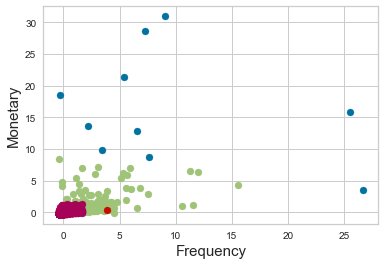

In [42]:
#Plot the clusters on 2D Frequency and Monetary (Agglomerative Hierarchical Clustering)
# Obtain all clusters which are unique
agg_clusters = unique(agg_labels)
print('Label of clusters =',agg_clusters)
# plot clusters
for agg_cluster in agg_clusters:
    # fetch data point that fall in this clstr
    index = where(agg_labels == agg_cluster)
    plt.scatter(customer_scaled.iloc[index[0],0], customer_scaled.iloc[index[0],1])
    
# Agglomerative hierarchy plot
plt.xlabel('Frequency', fontsize=15)
plt.ylabel('Monetary', fontsize=15)
plt.show()

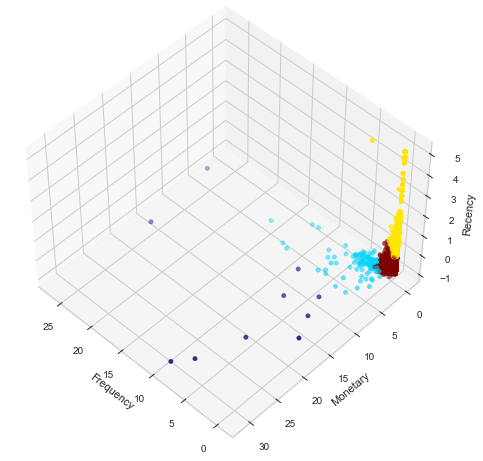

In [43]:
#Plot the clusters on 3D Recency,Frequency and Monetary (Agglomerative Hierarchical Clustering)
plot3D(customer_scaled['Frequency'], customer_scaled['Monetary'], customer_scaled['Recency'],'Frequency','Monetary','Recency',agg_labels)

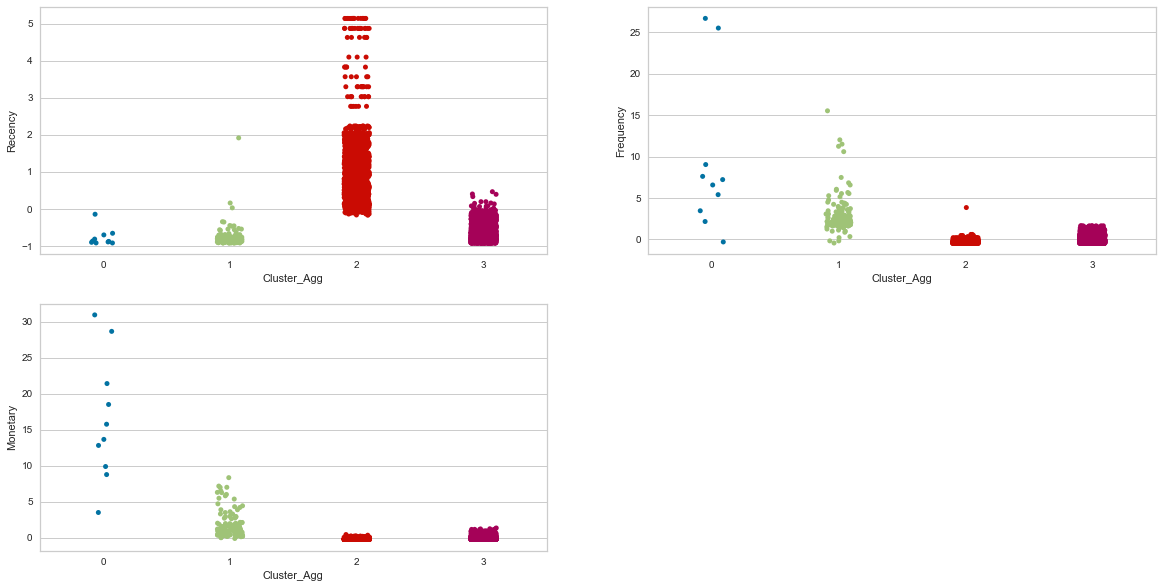

In [44]:
# make a copy customer scaled list to strip plot
customer_scaled_agg = customer_scaled.copy()
customer_scaled_agg['Cluster_Agg'] = agg_labels
# Strip plot for Recency, Frequency, Monetary (Agglomerative Hierarchical Clustering)
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
sb.stripplot(x='Cluster_Agg', y='Recency', data=customer_scaled_agg[['Cluster_Agg','Recency']])

plt.subplot(2,2,2)
sb.stripplot(x='Cluster_Agg', y='Frequency', data=customer_scaled_agg[['Cluster_Agg','Frequency']])

plt.subplot(2,2,3)
sb.stripplot(x='Cluster_Agg', y='Monetary', data=customer_scaled_agg[['Cluster_Agg','Monetary']])

plt.show()

In [45]:
# Group by clusters and mean to gain the insights (Agglomerative Hierarchical Clustering)
agg_summary = customer.groupby('Cluster_Agg')
agg_summary = agg_summary.agg(Frequency=('Frequency', np.mean), Monetary=('Monetary', np.mean), 
                           Recency=('Recency', np.mean), Customer_Total=('Recency', pd.Series.count))
# Calculate % of customer for each cluster
agg_summary['Customer_%'] = (agg_summary['Customer_Total']/agg_summary['Customer_Total'].sum())*100
agg_summary

,Frequency,Monetary,Recency,Customer_Total,Customer_%
Cluster_Agg,,,,,
0,76.300000,149481.278000,17.398889,10,0.230468
1,27.020690,16274.791862,16.969535,145,3.341784
2,1.806167,590.493236,225.100673,1589,36.621341
3,4.233141,1587.073816,37.783472,2595,59.806407


The above result of Agglomerative clustering is closely similar to the result of Kmean, it shows that there are 4 clusters of customer: two the best clusters, one promising and one worst
Now, we will try with DBSCAN clustering.

**DBSCAN clustering**

In [46]:
# Build DBSCAN model
# Define model
dbscan_model = DBSCAN(eps=0.3, min_samples=5)
# Train the model
dbscan_model.fit(customer_scaled)
# Assign each data point to a cluster
dbscan_labels = dbscan_model.fit_predict(customer_scaled)
# Calculate Silhoutte Score for DBSCAN clustering
dbscan_score = silhouette_score(customer_scaled, dbscan_labels, metric='euclidean')
# Print the score
print('DBSCAN Clustering - Silhouetter Score: %.3f' % dbscan_score)

DBSCAN Clustering - Silhouetter Score: 0.558


In [47]:
# Add labels of clusters into data
customer["Cluster_Dbscan"] = dbscan_labels
customer.head()

,Frequency,Monetary,Recency,Cluster_Km,Cluster_Agg,Cluster_Dbscan
CustomerID,,,,,,
12346,1,77183.60,326.304167,3,1,-1
12347,7,4310.00,40.204167,0,3,0
12348,4,1797.24,76.170833,0,3,0
12349,1,1757.55,19.311111,0,3,0
12350,1,334.40,311.054167,2,2,0


Labels of clusters =  [-1  0  1  2  3]


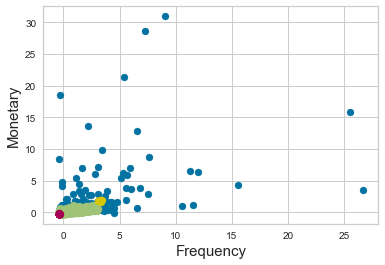

In [48]:
# Plot the clusters on 2D Frequency and Monetary (DBSCAN Clustering)
# obtain all the unique clusters
dbscan_clusters = unique(dbscan_labels)
print('Labels of clusters = ',dbscan_clusters)
# Plot the DBSCAN clusters
for dbscan_clus in dbscan_clusters:
    # Obtain data point that belong in this cluster
    index = where(dbscan_labels == dbscan_clus)
    # plot
    plt.scatter(customer_scaled.iloc[index[0], 0], customer_scaled.iloc[index[0], 1])
    
# show plot
plt.xlabel('Frequency', fontsize=15)
plt.ylabel('Monetary', fontsize=15)
plt.show()

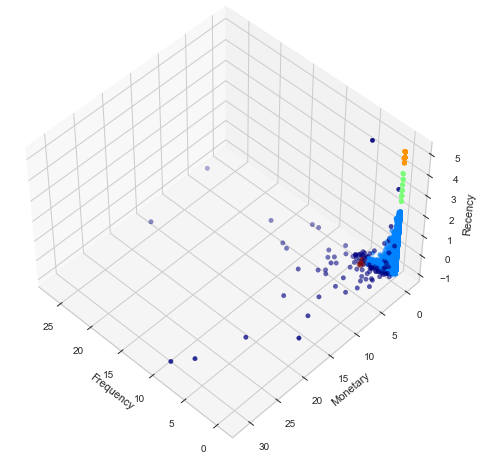

In [49]:
#Plot the clusters on 3D Recency,Frequency and Monetary (DBSCAN clustering)
plot3D(customer_scaled['Frequency'], customer_scaled['Monetary'], customer_scaled['Recency'],'Frequency','Monetary','Recency',dbscan_labels)

In [50]:
# Group by clusters and mean to gain the insights (DBSCAN)
dbscan_summary = customer.groupby('Cluster_Dbscan')
dbscan_summary = dbscan_summary.agg(Frequency=('Frequency', np.mean), Monetary=('Monetary', np.mean), 
                           Recency=('Recency', np.mean), Customer_Total=('Recency', pd.Series.count))
# Calculate % of customer for each cluster
dbscan_summary['Customer_%'] = (dbscan_summary['Customer_Total']/dbscan_summary['Customer_Total'].sum())*100
dbscan_summary

,Frequency,Monetary,Recency,Customer_Total,Customer_%
Cluster_Dbscan,,,,,
-1,32.010204,35064.426837,45.061239,98,2.258585
0,3.642290,1284.953535,98.237374,4157,95.805485
1,1.026316,246.362105,486.767964,38,0.875778
2,1.025000,276.193750,675.142986,40,0.921871
3,29.666667,18855.453333,12.664005,6,0.138281


The above result of DBSCAN clustering show that:
* There are 5 clusters which are assigned from -1 to 3
* The first cluster '-1': DBSCAN treats this cluster as outliers while it is the best customer cluster.
* The cluster '0' take over 95% of the customers
* There is a close similarity between the clusters 1 and 2 or -1 and 3

For this data, DBSCAN clustering provides non diverse segments, the segments could be hard to interpret. We will try DBSCAN again by changing the parameters epsilon and min samples.

In [51]:
#Build the other DBSCAN model with eps = 0.2 and min samples = 8
dbscan2_model = DBSCAN(eps=0.2, min_samples=8)
# Train the model
dbscan2_model.fit(customer_scaled)
# Assign each data point to a cluster
dbscan2_labels = dbscan2_model.fit_predict(customer_scaled)
dbscan2_customer = customer.copy()
dbscan2_customer["Cluster_Dbscan"] = dbscan2_labels

In [52]:
# Group by clusters and mean to gain the insights (DBSCAN)
dbscan2_summary = dbscan2_customer.groupby('Cluster_Dbscan')
dbscan2_summary = dbscan2_summary.agg(Frequency=('Frequency', np.mean), Monetary=('Monetary', np.mean), 
                           Recency=('Recency', np.mean), Customer_Total=('Recency', pd.Series.count))
# Calculate % of customer for each cluster
dbscan2_summary['Customer_%'] = (dbscan2_summary['Customer_Total']/dbscan2_summary['Customer_Total'].sum())*100
dbscan2_summary

,Frequency,Monetary,Recency,Customer_Total,Customer_%
Cluster_Dbscan,,,,,
-1,20.809091,18824.748273,110.745350,220,5.070293
0,3.402415,1152.221443,99.019961,4058,93.523853
1,1.000000,241.033333,485.191744,9,0.207421
2,1.000000,299.011765,666.166789,17,0.391795
3,1.058824,252.921765,697.152124,17,0.391795
4,1.000000,268.199000,454.197292,10,0.230468
5,12.125000,10001.813750,11.943837,8,0.184374


With the results obtained from above experiment, there is no doubt that DBSCAN does not fit this data. The segments are hard to interpret.

### Conclusion ###

DBSCAN don't fit this problem. On opposite sides, Kmean and Agglomerative clustering give us good results, the segments of customer are easy to interpret. Kmean has the best Silhouette score of 0.573, the Silhouette score of Agglemerative is a bit smaller with 0.51. Both show that there are four clusters of customer: 
* Two best clusters: they spent the big amount of money and made purchases most often, but they are the minority
* One promising: they are the majority, they spent quite a lot of money recently, but they didn’t make many transactions, so they are probably new customers. 
* One worst: they made last purchase a long time ago and spent little money. so it is worth to encourage them to go back by providing them with some special offers.




### Thank you for reading ###

## Author ##
Tho Quy Ngo
